In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 02-06-2025: Quality Control

## GToTree Genomes_summary_info.tsv

We looked at the summary from GToTree to find out how complete the single copy genes in our genomes are compared to the GTDB. In particular, we tried to see whether complete genomes had different completeness and redundancy percentages than incomplete genomes.


In [5]:
df = pd.read_table("data/gtotree/Genomes_summary_info.tsv")
df["is_complete"] = ["Yes","No","Yes","Yes","Yes","Yes","No","Yes","Yes","Yes","Yes","No","Yes","No","No","No","No"]
df["is_endosymb"] = ["No","Yes","Yes","Yes","Yes","No","Yes","Yes","No","Yes","No","Yes","Yes","Yes","Yes","Yes","Yes"]
df


,assembly_id,taxid,num_SCG_hits,uniq_SCG_hits,perc_comp,perc_redund,num_SCG_hits_after_len_filt,in_final_tree,GTDB_accession,GTDB_domain,GTDB_phylum,GTDB_class,GTDB_order,GTDB_family,GTDB_genus,GTDB_species,is_complete,is_endosymb
0,Dickeya_dadantii_XJ12_GCF_030168535.1,NaN,167,163,97.09,2.33,162,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
1,Doolittlea_endobia_DEMHIR_GCF_900039485.1,NaN,110,110,63.95,0.00,105,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
2,Gullanella_endobia_GEFVIR_GCF_900048035.1,NaN,106,106,61.63,0.00,105,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
3,Mikella_endobia_mEPMAR_GCF_900048045.1,NaN,75,75,43.60,0.00,72,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
4,Moranella_endobia_GCF_000364725.1,NaN,96,96,55.81,0.00,95,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
5,Pectobacterium_cacticida_CFBP3628_GCF_036885195.1,NaN,170,169,98.84,0.58,167,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
6,Sodalis_endolongispinus_SOD1_GCF_018777395.1,NaN,167,158,97.09,5.81,152,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
7,Sodalis_glossinidius_morsitans_GCF_000010085.1,NaN,169,168,98.26,1.16,165,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
8,Sodalis_ligni_dw23_GCF_016865525.2,NaN,168,161,97.67,4.07,157,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
9,Sodalis_pierantonius_SOPE_GCF_000517405.1,NaN,164,156,95.35,5.81,153,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

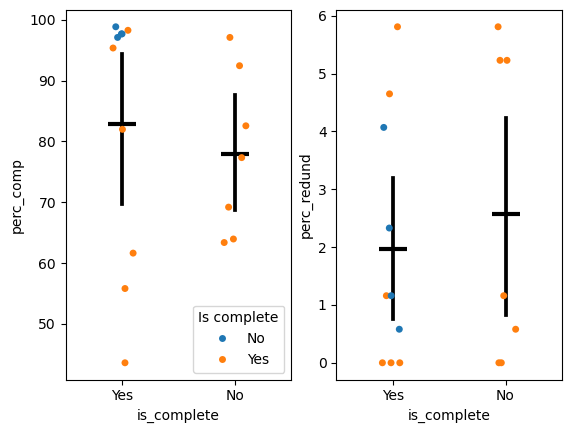

In [6]:
fig, axes = plt.subplots(1,2)

sns.stripplot(data=df,x="is_complete",y="perc_comp",hue="is_endosymb", ax = axes[0])
sns.pointplot(data=df,x="is_complete",y="perc_comp",linestyle="none",errorbar="ci",marker="_",markersize=20,markeredgewidth=3,ax=axes[0],color="black")

sns.stripplot(data=df,x="is_complete",y="perc_redund",hue="is_endosymb", ax = axes[1],legend=False)
sns.pointplot(data=df,x="is_complete",y="perc_redund",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[1],color="black")

handles, labels = axes[1].get_legend_handles_labels()
axes[0].legend(title="Is complete", loc='lower right')

plt.tight_layout

The free-living, complete genomes have a completion percentage that's close to 100%. The endosymbiotic completed genomes can have completion percentages as low as 43%. Looking at the 95% CI error bars, there's no significant difference in completion percentage between complete and incomplete genomes. 

Redundancy percentages are generally below 6% and do not differ significantly between complete and incomplete genomes.



## Seqkit and Quast

We ran seqkit v2.10.0 and quast v5.0.0 on all of the genomes to generate more quality statistics, using the following commands:
```sh
mkdir quality
cd quality

seqkit stats -a ../data/genomes/* > seqkit_stats.tsv
sed -ie "s/[[:space:]]\+/\t/g" seqkit_stats.tsv
sed -ie "s/\.fna//g" seqkit_stats.tsv

for f in ../data/genomes/*; do mkdir quast_$f; quast -o quast_$f $f; done
for f in *.fna; do mv $f $(echo $f | cut -d"." -f1,2); done
```

In [16]:
df2 = pd.read_table("quality/seqkit_stats.tsv")
df = pd.merge(df, df2, left_on="assembly_id", right_on="file")
df

,assembly_id,taxid,num_SCG_hits,uniq_SCG_hits,perc_comp,perc_redund,num_SCG_hits_after_len_filt,in_final_tree,GTDB_accession,GTDB_domain,...,Q2,Q3,sum_gap,N50,N50_num,Q20(%),Q30(%),AvgQual,GC(%),sum_n
0,Dickeya_dadantii_XJ12_GCF_030168535.1,NaN,167,163,97.09,2.33,162,Yes,NaN,NaN,...,"4,972,118","4,972,118",0,"4,972,118",1,0,0,0,56.30,0
1,Doolittlea_endobia_DEMHIR_GCF_900039485.1,NaN,110,110,63.95,0.00,105,Yes,NaN,NaN,...,"423,281","834,734",0,"834,734",1,0,0,0,44.12,0
2,Gullanella_endobia_GEFVIR_GCF_900048035.1,NaN,106,106,61.63,0.00,105,Yes,NaN,NaN,...,"938,041","938,041",0,"938,041",1,0,0,0,28.90,0
3,Mikella_endobia_mEPMAR_GCF_900048045.1,NaN,75,75,43.60,0.00,72,Yes,NaN,NaN,...,"352,837","352,837",0,"352,837",1,0,0,0,30.56,0
4,Moranella_endobia_GCF_000364725.1,NaN,96,96,55.81,0.00,95,Yes,NaN,NaN,...,"538,203","538,203",0,"538,203",1,0,0,0,43.52,0
5,Pectobacterium_cacticida_CFBP3628_GCF_036885195.1,NaN,170,169,98.84,0.58,167,Yes,NaN,NaN,...,"4,116,584","4,116,584",0,"4,116,584",1,0,0,0,50.97,0
6,Sodalis_endolongispinus_SOD1_GCF_018777395.1,NaN,167,158,97.09,5.81,152,Yes,NaN,NaN,...,"473,745","1,774,593.5",0,"2,691,569",1,0,0,0,56.43,0
7,Sodalis_glossinidius_morsitans_GCF_000010085.1,NaN,169,168,98.26,1.16,165,Yes,NaN,NaN,...,"55,273","2,127,226",0,"4,171,146",1,0,0,0,54.50,0
8,Sodalis_ligni_dw23_GCF_016865525.2,NaN,168,161,97.67,4.07,157,Yes,NaN,NaN,...,"6,443,694","6,443,694",0,"6,443,694",1,0,0,0,54.96,3
9,Sodalis_pierantonius_SOPE_GCF_000517405.1,NaN,164,156,95.35,5.81,153,Yes,NaN,NaN,...,"4,513,140","4,513,140",0,"4,513,140",1,0,0,0,56.06,0


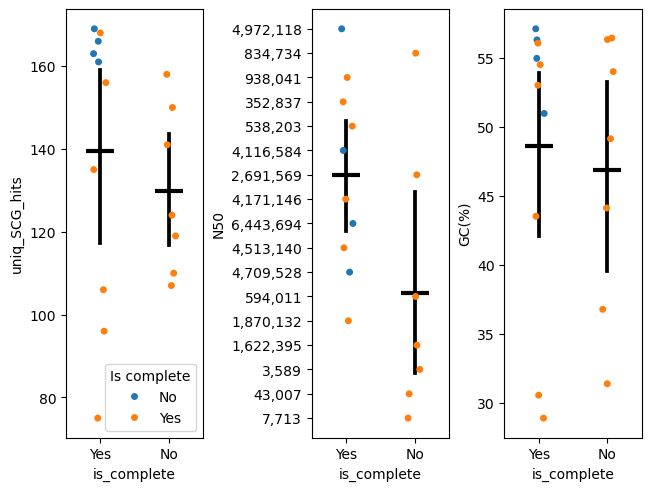

In [22]:
fig, axes = plt.subplots(1,3,constrained_layout=True)

sns.stripplot(data=df,x="is_complete",y="uniq_SCG_hits",hue="is_endosymb", ax = axes[0])
sns.pointplot(data=df,x="is_complete",y="uniq_SCG_hits",linestyle="none",errorbar="ci",marker="_",markersize=20,markeredgewidth=3,ax=axes[0],color="black")

sns.stripplot(data=df,x="is_complete",y="N50",hue="is_endosymb", ax = axes[1],legend=False)
sns.pointplot(data=df,x="is_complete",y="N50",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[1],color="black")

sns.stripplot(data=df,x="is_complete",y="GC(%)",hue="is_endosymb", ax = axes[2],legend=False)
sns.pointplot(data=df,x="is_complete",y="GC(%)",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[2],color="black")

handles, labels = axes[2].get_legend_handles_labels()
axes[0].legend(title="Is complete", loc='lower right')

plt.show()